Nama : Ananda Fitri Karimah <br>
NIM : 2301212019 <br>
Big Data Analysis <br>



# Import Data

In [ ]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 19.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=3ec7a9f0df38a389b6b5327f4b29105b75cfb657c67239e2a079ffceea399b85
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('Colab_pyspark').getOrCreate()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Untuk visualisasi
import seaborn as sns                 # Untuk visualisasi
plt.style.use("seaborn")

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MAGISTER/BIG DATA ANALYSIS/ASSESMENT 3'

In [ ]:
df_super = spark.read.csv(path+"/dataset/50_SupermarketBranches.csv", header=True, inferSchema=True)
df_ads = spark.read.csv(path+"/dataset/Ads_CTR_Optimisation.csv", header=True, inferSchema=True)
df_basket = spark.read.csv(path+"/dataset/Market_Basket_Optimisation.csv").toDF("col1","col2","col3", "col4","col5","col6","col7","col8","col9","col10","col11","col12", "col13","col14","col15", "col16","col17","col18", "col19","col20")
# df = spark.read.csv(filename).toDF("col1","col2","col3")
df_member = spark.read.csv(path+"/dataset/Supermarket_CustomerMembers.csv", header=True, inferSchema=True)

# Data Supermarket Branches

In [ ]:
df_super.show(10,False)

+-------------------+---------------+--------------------+----------+---------+
|Advertisement Spend|Promotion Spend|Administration Spend|State     |Profit   |
+-------------------+---------------+--------------------+----------+---------+
|165349.2           |136897.8       |471784.1            |New York  |192261.83|
|162597.7           |151377.59      |443898.53           |California|191792.06|
|153441.51          |101145.55      |407934.54           |Florida   |191050.39|
|144372.41          |118671.85      |383199.62           |New York  |182901.99|
|142107.34          |91391.77       |366168.42           |Florida   |166187.94|
|131876.9           |99814.71       |362861.36           |New York  |156991.12|
|134615.46          |147198.87      |127716.82           |California|156122.51|
|130298.13          |145530.06      |323876.68           |Florida   |155752.6 |
|120542.52          |148718.95      |311613.29           |New York  |152211.77|
|123334.88          |108679.17      |304

In [ ]:
print((df_super.count(), len(df_super.columns)))

(50, 5)


In [ ]:
df_super_pandas = df_super.toPandas()

In [ ]:
print("Jumlah data sebelum drop null:", df_super.count())
df_super = df_super.na.drop("any")
print("Jumlah data setelah drop null : ",df_super.count())

Jumlah data sebelum drop null: 50
Jumlah data setelah drop null :  50


In [ ]:
df_super_pandas['State'].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

In [ ]:
df_super = df_super.withColumnRenamed("Advertisement Spend","ads_spend")\
.withColumnRenamed("Promotion Spend","promote_spend")\
.withColumnRenamed("Administration Spend","adm_spend")

In [ ]:
df_super = df_super.withColumn('tot_spending', df_super.ads_spend + df_super.promote_spend + df_super.adm_spend)

In [ ]:
df_super = df_super.withColumn('omzet', df_super.tot_spending + df_super.Profit)

In [ ]:
df_super.show()

+---------+-------------+---------+----------+---------+------------------+-----------------+
|ads_spend|promote_spend|adm_spend|     State|   Profit|      tot_spending|            omzet|
+---------+-------------+---------+----------+---------+------------------+-----------------+
| 165349.2|     136897.8| 471784.1|  New York|192261.83|          774031.1|966292.9299999999|
| 162597.7|    151377.59|443898.53|California|191792.06| 757873.8200000001|949665.8800000001|
|153441.51|    101145.55|407934.54|   Florida|191050.39|          662521.6|        853571.99|
|144372.41|    118671.85|383199.62|  New York|182901.99|         646243.88|        829145.87|
|142107.34|     91391.77|366168.42|   Florida|166187.94|         599667.53|        765855.47|
| 131876.9|     99814.71|362861.36|  New York|156991.12|         594552.97|        751544.09|
|134615.46|    147198.87|127716.82|California|156122.51|409531.14999999997|565653.6599999999|
|130298.13|    145530.06|323876.68|   Florida| 155752.6|    

## EDA

### Count Startup Capital (Modal) Each Branch

In [ ]:
df_super_pandas = df_super.toPandas()
df_super_pandas.describe()

,ads_spend,promote_spend,adm_spend,Profit,tot_spending,omzet
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000
mean,73721.615600,121344.639600,211025.097800,112012.639200,406091.353000,518103.99220
std,45902.256482,28017.802755,122290.310726,40306.180338,162419.010502,198568.44707
min,0.000000,51283.140000,0.000000,14681.400000,52285.200000,87958.61000
25%,39936.370000,103730.875000,129300.132500,90138.902500,293421.857500,378742.15750
50%,73051.080000,122699.795000,212716.240000,107978.190000,411888.640000,490879.06000
75%,101602.800000,144842.180000,299469.085000,139765.977500,516942.917500,639618.33750
max,165349.200000,182645.560000,471784.100000,192261.830000,774031.100000,966292.93000


In [ ]:
df_super_pandas_cali = df_super_pandas[df_super_pandas['State']=='California']
df_super_pandas_flo = df_super_pandas[df_super_pandas['State']=='Florida']
df_super_pandas_ny = df_super_pandas[df_super_pandas['State']=='New York']

In [ ]:
df_super_pandas_cali.head()

,ads_spend,promote_spend,adm_spend,State,Profit,tot_spending,omzet
1,162597.70,151377.59,443898.53,California,191792.06,757873.82,949665.88
6,134615.46,147198.87,127716.82,California,156122.51,409531.15,565653.66
9,123334.88,108679.17,304981.62,California,149759.96,536995.67,686755.63
11,100671.96,91790.61,249744.55,California,144259.40,442207.12,586466.52
13,91992.39,135495.07,252664.93,California,134307.35,480152.39,614459.74


In [ ]:
sum_profit_cali = df_super_pandas_cali['Profit'].sum()
sum_spend_cali = df_super_pandas_cali['tot_spending'].sum()

sum_profit_flo = df_super_pandas_flo['Profit'].sum()
sum_spend_flo = df_super_pandas_flo['tot_spending'].sum()

sum_profit_ny = df_super_pandas_ny['Profit'].sum()
sum_spend_ny = df_super_pandas_ny['tot_spending'].sum()

In [ ]:
print('Total Profit California : ', sum_profit_cali)
print('Total Spending California : ', sum_spend_cali)
print('Total Pendapatan Cabang California : ', sum_profit_cali+sum_spend_cali)
print("==============================================")
print('Total Profit Florida : ', sum_profit_flo)
print('Total Spending Florida : ', sum_spend_flo)
print('Total Pendapatan Cabang Florida : ', sum_profit_flo+sum_spend_flo)
print("==============================================")
print('Total Profit New York : ', sum_profit_ny)
print('Total Spending New York : ', sum_spend_ny)
print('Total Pendapatan Cabang New York: ', sum_profit_ny+sum_spend_ny)

Total Profit California :  1766387.98
Total Spending California :  6255066.88
Total Pendapatan Cabang California :  8021454.859999999
Total Profit Florida :  1900384.39
Total Spending Florida :  7197063.44
Total Pendapatan Cabang Florida :  9097447.83
Total Profit New York :  1933859.5899999996
Total Spending New York :  6852437.329999999
Total Pendapatan Cabang New York:  8786296.919999998


### Count Margin Profit Each Branch

In [ ]:
perc_untung_cali = (sum_profit_cali/(sum_profit_cali+sum_spend_cali))*100
perc_untung_flo = (sum_profit_flo/(sum_profit_flo+sum_spend_flo))*100
perc_untung_ny = (sum_profit_ny/(sum_profit_ny+sum_spend_ny))*100

In [ ]:
print('Margin Profit yang didapatkan Cabang California : ', perc_untung_cali, "%")
print('Margin Profit yang didapatkan Cabang Florida : ', perc_untung_flo, "%")
print('Margin Profit yang didapatkan Cabang New York : ', perc_untung_ny, "%")

Margin Profit yang didapatkan Cabang California :  22.020793120813 %
Margin Profit yang didapatkan Cabang Florida :  20.889203494338695 %
Margin Profit yang didapatkan Cabang New York :  22.00995035346472 %


In [ ]:
selisih_cf = (sum_profit_flo+sum_spend_flo)-(sum_profit_cali+sum_spend_cali)
selisih_nf = (sum_profit_flo+sum_spend_flo)-(sum_profit_ny+sum_spend_ny)

print(selisih_cf)
print(selisih_nf)

1075992.9700000007
311150.910000002


## Clustering<br>

Diuji cobakan penggunaan clustering untuk melihat pengelompokan/penggolongan modal terhadap total spending untuk supermarket ABC ini

In [ ]:
sel_col = ['tot_spending', 'omzet']
assemble = VectorAssembler(inputCols=sel_col, outputCol = 'feat_target')
assembled_df_super = assemble.transform(df_super)

In [ ]:
eval = ClusteringEvaluator(predictionCol='prediction',
                           featuresCol='feat_target',
                           metricName='silhouette',
                           distanceMeasure='squaredEuclidean')

In [ ]:
silhouette_scores=[]
print("""
Silhouette Scores for K Mean Clustering
=======================================
Model\tScore\t
=====\t=====\t
""")

for K in range(2,11):

    KMeans_algo=KMeans(featuresCol='feat_target', k=K)
    KMeans_fit=KMeans_algo.fit(assembled_df_super)
    output=KMeans_fit.transform(assembled_df_super)
    score=eval.evaluate(output)
    silhouette_scores.append(score)
    print(f"K{K}\t{round(score,2)}\t")


Silhouette Scores for K Mean Clustering
Model	Score	
=====	=====	

K2	0.77	
K3	0.72	
K4	0.77	
K5	0.72	
K6	0.69	
K7	0.67	
K8	0.67	
K9	0.59	
K10	0.63	


Text(0, 0.5, 'Silhouette Score')

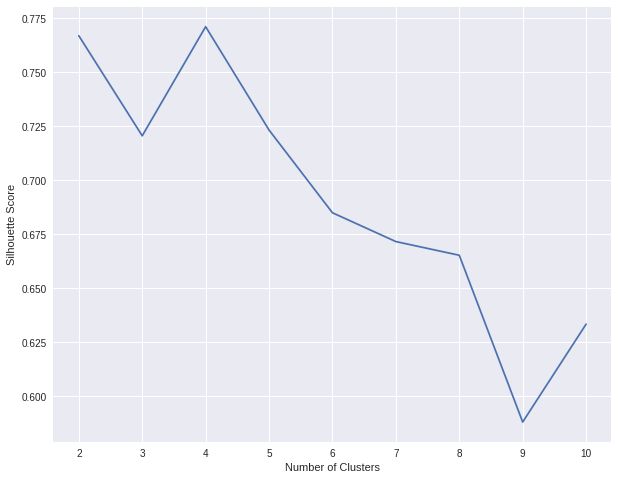

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [ ]:
KMeans_algorithm=KMeans(featuresCol='feat_target', k=2)
Model=KMeans_algorithm.fit(assembled_df_super)
KMeans_Assignments=Model.transform(assembled_df_super)

In [ ]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=2, inputCol="feat_target", outputCol="pca")
pca_model = pca.fit(assembled_df_super)
pca_transformed = pca_model.transform(assembled_df_super)

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

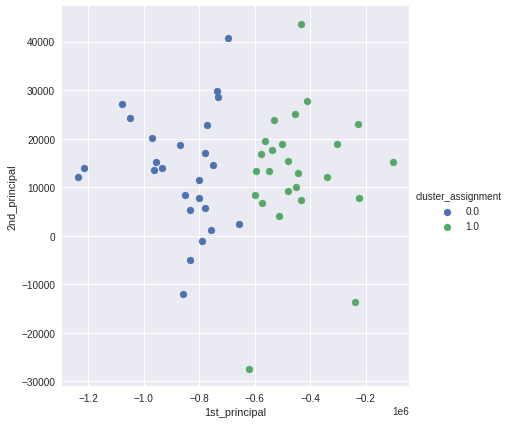

In [ ]:
pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [ ]:
KMeans_Assignments.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   25|
|         0|   25|
+----------+-----+



In [ ]:
df_super_clust = KMeans_Assignments.toPandas()
df_super_clust_pandas = pd.DataFrame(df_super_clust)
df_super_clust_pandas.head()

,ads_spend,promote_spend,adm_spend,State,Profit,tot_spending,omzet,feat_target,prediction
0,165349.20,136897.80,471784.10,New York,192261.83,774031.10,966292.93,"[774031.1, 966292.9299999999]",0
1,162597.70,151377.59,443898.53,California,191792.06,757873.82,949665.88,"[757873.8200000001, 949665.8800000001]",0
2,153441.51,101145.55,407934.54,Florida,191050.39,662521.60,853571.99,"[662521.6, 853571.99]",0
3,144372.41,118671.85,383199.62,New York,182901.99,646243.88,829145.87,"[646243.88, 829145.87]",0
4,142107.34,91391.77,366168.42,Florida,166187.94,599667.53,765855.47,"[599667.53, 765855.47]",0


In [ ]:
for i in range(2):
  print(f'Cluster ke-{i}')
  print('Rata-rata Total Spending  : ', df_super_clust_pandas[df_super_clust_pandas['prediction']==i]['tot_spending'].mean())
  print('Rata-rata Omzet : ', df_super_clust_pandas[df_super_clust_pandas['prediction']==i]['omzet'].mean())

Cluster ke-0
Rata-rata Total Spending  :  539319.4968
Rata-rata Omzet :  681361.5240000001
Cluster ke-1
Rata-rata Total Spending  :  272863.20920000004
Rata-rata Omzet :  354846.4604


In [ ]:
df_super_clust_pandas_0= df_super_clust_pandas[df_super_clust_pandas['prediction']==0]
df_super_clust_pandas_1= df_super_clust_pandas[df_super_clust_pandas['prediction']==1]
# df_super_clust_pandas_2= df_super_clust_pandas[df_super_clust_pandas['prediction']==2]
# df_super_clust_pandas_3= df_super_clust_pandas[df_super_clust_pandas['prediction']==3]

In [ ]:
df_super_clust_pandas_0['State'].value_counts()

Florida       9
New York      8
California    8
Name: State, dtype: int64

In [ ]:
df_super_clust_pandas_1['State'].value_counts()

New York      9
California    9
Florida       7
Name: State, dtype: int64

In [ ]:
# df_super_clust_pandas_2['State'].value_counts()

In [ ]:
# df_super_clust_pandas_3['State'].value_counts()

# Data Ads Optimization

In [ ]:
df_ads.show(10,False)

+----+----+----+----+----+----+----+----+----+-----+
|Ad 1|Ad 2|Ad 3|Ad 4|Ad 5|Ad 6|Ad 7|Ad 8|Ad 9|Ad 10|
+----+----+----+----+----+----+----+----+----+-----+
|1   |0   |0   |0   |1   |0   |0   |0   |1   |0    |
|0   |0   |0   |0   |0   |0   |0   |0   |1   |0    |
|0   |0   |0   |0   |0   |0   |0   |0   |0   |0    |
|0   |1   |0   |0   |0   |0   |0   |1   |0   |0    |
|0   |0   |0   |0   |0   |0   |0   |0   |0   |0    |
|1   |1   |0   |0   |0   |0   |0   |0   |0   |0    |
|0   |0   |0   |1   |0   |0   |0   |0   |0   |0    |
|1   |1   |0   |0   |1   |0   |0   |0   |0   |0    |
|0   |0   |0   |0   |0   |0   |0   |0   |0   |0    |
|0   |0   |1   |0   |0   |0   |0   |0   |0   |0    |
+----+----+----+----+----+----+----+----+----+-----+
only showing top 10 rows



In [ ]:
print("Jumlah data sebelum drop null:", df_ads.count())
df_ads = df_ads.na.drop("any")
print("Jumlah data setelah drop null : ",df_ads.count())

Jumlah data sebelum drop null: 10000
Jumlah data setelah drop null :  10000


In [ ]:
print((df_ads.count(), len(df_ads.columns)))

(10000, 10)


## EDA

In [ ]:
df_ads_pandas = df_ads.toPandas()
df_ads_pandas.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_ads_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ad 1    10000 non-null  int32
 1   Ad 2    10000 non-null  int32
 2   Ad 3    10000 non-null  int32
 3   Ad 4    10000 non-null  int32
 4   Ad 5    10000 non-null  int32
 5   Ad 6    10000 non-null  int32
 6   Ad 7    10000 non-null  int32
 7   Ad 8    10000 non-null  int32
 8   Ad 9    10000 non-null  int32
 9   Ad 10   10000 non-null  int32
dtypes: int32(10)
memory usage: 390.8 KB


### Findout The most high click rate Ads

In [ ]:
arr_click_rate = []

In [ ]:
for i in range(10):
  print('=============================')
  print(df_ads_pandas.columns[i])
  print(df_ads_pandas[df_ads_pandas.columns[i]].value_counts())
  arr_click_rate.append(df_ads_pandas[df_ads_pandas.columns[i]].value_counts()[1])

Ad 1
0    8297
1    1703
Name: Ad 1, dtype: int64
Ad 2
0    8705
1    1295
Name: Ad 2, dtype: int64
Ad 3
0    9272
1     728
Name: Ad 3, dtype: int64
Ad 4
0    8804
1    1196
Name: Ad 4, dtype: int64
Ad 5
0    7305
1    2695
Name: Ad 5, dtype: int64
Ad 6
0    9874
1     126
Name: Ad 6, dtype: int64
Ad 7
0    8888
1    1112
Name: Ad 7, dtype: int64
Ad 8
0    7909
1    2091
Name: Ad 8, dtype: int64
Ad 9
0    9048
1     952
Name: Ad 9, dtype: int64
Ad 10
0    9511
1     489
Name: Ad 10, dtype: int64


In [ ]:
# print(arr_click_rate)
print('Rata-rata Click rate : ', np.mean(arr_click_rate))
print('Max Click rate : ', np.max(arr_click_rate))
print('Min Click rate : ', np.min(arr_click_rate))

Rata-rata Click rate :  1238.7
Max Click rate :  2695
Min Click rate :  126


# Data Market Basket

In [ ]:
df_basket.show(50,False)

+-----------------+-----------------+--------------+-------------------+-------------+----------------+---------------+---------------+------------+--------------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|col1             |col2             |col3          |col4               |col5         |col6            |col7           |col8           |col9        |col10               |col11         |col12    |col13|col14|col15        |col16 |col17            |col18          |col19  |col20    |
+-----------------+-----------------+--------------+-------------------+-------------+----------------+---------------+---------------+------------+--------------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|shrimp           |almonds          |avocado       |vegetables mix     |green grapes |whole weat flour|yams           |cottage cheese |energy drink|tomato juice

In [ ]:
print((df_basket.count(), len(df_basket.columns)))

(7501, 20)


## EDA

In [ ]:
df_basket_pandas = df_basket.toPandas()
df_basket_pandas.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,chutney,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,turkey,avocado,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,mineral water,milk,energy bar,whole wheat rice,green tea,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
df_basket_pandas.fillna("-", inplace = True)
df_basket_pandas.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,chutney,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,turkey,avocado,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,mineral water,milk,energy bar,whole wheat rice,green tea,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [ ]:
arr_basket = {}
for i in range(20):
  print('=============================')
  print(df_basket_pandas.columns[i])
  print(df_basket_pandas[df_basket_pandas.columns[i]].value_counts())
  arr_basket['col_{}'.format(i)] = df_basket_pandas[df_basket_pandas.columns[i]].value_counts()

col1
mineral water        577
burgers              576
turkey               458
chocolate            391
frozen vegetables    373
                    ... 
cauliflower            1
ketchup                1
cream                  1
body spray             1
oatmeal                1
Name: col1, Length: 115, dtype: int64
col2
-                1754
mineral water     484
spaghetti         411
eggs              302
ground beef       291
                 ... 
asparagus           2
chili               1
water spray         1
cream               1
cauliflower         1
Name: col2, Length: 118, dtype: int64
col3
-                   3112
mineral water        375
spaghetti            279
eggs                 225
milk                 213
                    ... 
pickles                1
cream                  1
water spray            1
hand protein bar       1
cauliflower            1
Name: col3, Length: 116, dtype: int64
col4
-                4156
mineral water     201
eggs              181
french f

In [ ]:
list_basket = pd.DataFrame(arr_basket)
list_basket.head(10)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
asparagus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-,NaN,1754.0,3112.0,4156.0,4972.0,5637.0,6132.0,6520.0,6847.0,7106.0,7245.0,7347.0,7414.0,7454.0,7476.0,7493.0,7497.0,7497.0,7498.0,7500.0
almonds,11.0,29.0,35.0,29.0,12.0,13.0,10.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antioxydant juice,18.0,10.0,12.0,6.0,3.0,6.0,2.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
asparagus,3.0,2.0,5.0,4.0,4.0,3.0,2.0,7.0,2.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avocado,57.0,64.0,46.0,43.0,18.0,9.0,7.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
babies food,5.0,5.0,4.0,3.0,2.0,6.0,2.0,1.0,2.0,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
bacon,6.0,8.0,12.0,11.0,8.0,6.0,5.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
barbecue sauce,3.0,9.0,18.0,10.0,11.0,10.0,8.0,4.0,4.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
black tea,9.0,31.0,15.0,9.0,16.0,14.0,7.0,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
list_basket.shape

(121, 20)

In [ ]:
list_basket.fillna(0, inplace = True)
list_basket.drop('-', inplace=True)
list_basket.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
asparagus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
almonds,11.0,29.0,35.0,29.0,12.0,13.0,10.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
antioxydant juice,18.0,10.0,12.0,6.0,3.0,6.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
asparagus,3.0,2.0,5.0,4.0,4.0,3.0,2.0,7.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
avocado,57.0,64.0,46.0,43.0,18.0,9.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# sum_basket = np.cumsum(list_basket,axis=0)
#

sum_basket = list_basket.reset_index()
sum_basket.head()

,index,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,asparagus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,almonds,11.0,29.0,35.0,29.0,12.0,13.0,10.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,antioxydant juice,18.0,10.0,12.0,6.0,3.0,6.0,2.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,asparagus,3.0,2.0,5.0,4.0,4.0,3.0,2.0,7.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,avocado,57.0,64.0,46.0,43.0,18.0,9.0,7.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sum_column = list_basket.sum(axis=1)
sum_column_df = pd.DataFrame(sum_column)
sum_column_df.drop(' asparagus', inplace=True)
sum_column_df.reset_index(inplace=True)
sum_column_df.rename(columns={0: "total"}, inplace=True)
sum_column_df=sum_column_df.replace(35.0,36.0)
# sum_column_df.head(20)
sum_column_df.head()

,index,total
0,almonds,153.0
1,antioxydant juice,67.0
2,asparagus,36.0
3,avocado,250.0
4,babies food,34.0


In [ ]:
sum_column_df.shape

(119, 2)

In [ ]:
print(sum_column_df['total'].sum())

29363.0


In [ ]:
# sum_column_df.head(20)

In [ ]:
# sum_basket['total'] = sum_column_df[0]
# sum_basket.head()

In [ ]:
# sum_basket.shape

### Count Last 5 and Top 5 Item

In [ ]:
# sel_col = ['index', 'total']
# df_sort_basket = sum_basket[sel_col]

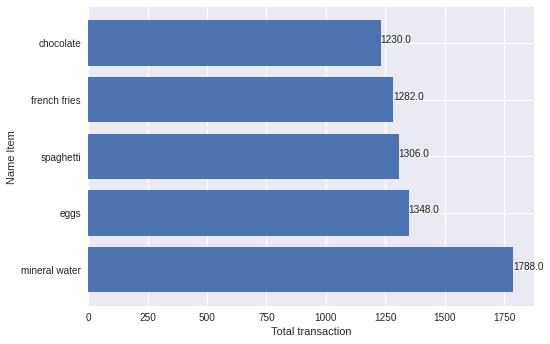

In [ ]:
# sel_col = ['index', 'total']
# df_sort_basket = sum_basket[sel_col]
sum_column_df = sum_column_df.sort_values(by=['total'],ascending=False)

# top 5 market basket
top5 = sum_column_df.head(5)

#visualize
index = top5['index']
total = top5['total']
bars = plt.barh(index, total)

for  bar in bars:
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    plt.text(width, label_y, s=f'{width}')

plt.xlabel("Total transaction")
plt.ylabel("Name Item")
plt.show()

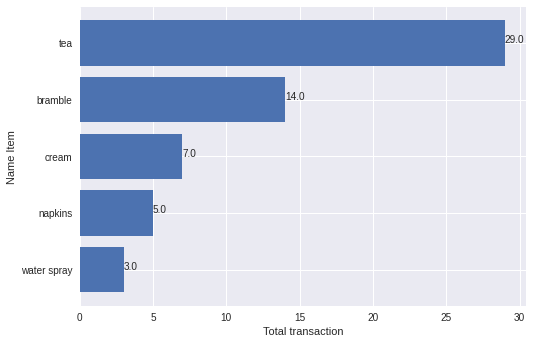

In [ ]:
sum_column_df = sum_column_df.sort_values(by=['total'],ascending=True)

#last 5 market basket
last5 = sum_column_df.head(5)

#visualize
index = last5['index']
total = last5['total']
bars = plt.barh(index, total)

for  bar in bars:
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    plt.text(width, label_y, s=f'{width}')

plt.xlabel("Total transaction")
plt.ylabel("Name Item")
plt.show()

# Data Customer Member

In [ ]:
df_member.show(4,False)

+----------+------+---+------------------+----------------------+
|CustomerID|Genre |Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|1         |Male  |19 |15                |39                    |
|2         |Male  |21 |15                |81                    |
|3         |Female|20 |16                |6                     |
|4         |Female|23 |16                |77                    |
+----------+------+---+------------------+----------------------+
only showing top 4 rows



In [ ]:
print("Jumlah data sebelum drop null:", df_member.count())
df_member = df_member.na.drop("any")
print("Jumlah data setelah drop null : ",df_member.count())

Jumlah data sebelum drop null: 200
Jumlah data setelah drop null :  200


In [ ]:
print((df_member.count(), len(df_member.columns)))

(200, 5)


## EDA

In [ ]:
df_member_pandas = df_member.toPandas()
df_member_pandas.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# df_member_pandas[df_member_pandas.columns[5]].value_counts()

In [ ]:
df_member_pandas[df_member_pandas.columns[-1]].value_counts()

42    8
55    7
46    6
73    6
35    5
     ..
31    1
44    1
53    1
65    1
18    1
Name: Spending Score (1-100), Length: 84, dtype: int64

In [ ]:
df_member_pandas[df_member_pandas.columns[1]].value_counts()

Female    112
Male       88
Name: Genre, dtype: int64

In [ ]:
df_member_pandas.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## Data Preprocessing

### UDF

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [ ]:
def dis_age(Age):
  if(Age < 25) :
    return "usia muda"
  elif (Age >= 25 and Age <= 34):
    return 'usia pekerja awal'
  elif (Age > 34 and Age <= 44):
    return 'usia paruh baya'
  elif (Age > 44 and Age <= 54):
    return 'usia pra-pensiun'
  elif (Age > 54):
    return 'usia pensiun'
  else :
    return 'error'

In [ ]:
Age_udf = udf(dis_age)
df_member = df_member.withColumn('Age_udf', Age_udf('Age'))
df_member.show(5, False)

+----------+------+---+------------------+----------------------+-----------------+
|CustomerID|Genre |Age|Annual Income (k$)|Spending Score (1-100)|Age_udf          |
+----------+------+---+------------------+----------------------+-----------------+
|1         |Male  |19 |15                |39                    |usia muda        |
|2         |Male  |21 |15                |81                    |usia muda        |
|3         |Female|20 |16                |6                     |usia muda        |
|4         |Female|23 |16                |77                    |usia muda        |
|5         |Female|31 |17                |40                    |usia pekerja awal|
+----------+------+---+------------------+----------------------+-----------------+
only showing top 5 rows



### OneHotEncoder

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='Age_udf', outputCol='Age_ohe')
indexer_fitted = indexer.fit(df_member)
df_member= indexer_fitted.transform(df_member)
df_member.show(2)

+----------+-----+---+------------------+----------------------+---------+-------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|  Age_udf|Age_ohe|
+----------+-----+---+------------------+----------------------+---------+-------+
|         1| Male| 19|                15|                    39|usia muda|    3.0|
|         2| Male| 21|                15|                    81|usia muda|    3.0|
+----------+-----+---+------------------+----------------------+---------+-------+
only showing top 2 rows



In [ ]:
indexer = StringIndexer(inputCol='Genre', outputCol='Genre_ohe')
indexer_fitted = indexer.fit(df_member)
df_member= indexer_fitted.transform(df_member)
df_member.show(2)

+----------+-----+---+------------------+----------------------+---------+-------+---------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|  Age_udf|Age_ohe|Genre_ohe|
+----------+-----+---+------------------+----------------------+---------+-------+---------+
|         1| Male| 19|                15|                    39|usia muda|    3.0|      1.0|
|         2| Male| 21|                15|                    81|usia muda|    3.0|      1.0|
+----------+-----+---+------------------+----------------------+---------+-------+---------+
only showing top 2 rows



In [ ]:
df_member_pandas2 = df_member.toPandas()
df_member_pandas2.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Age_udf,Age_ohe,Genre_ohe
0,1,Male,19,15,39,usia muda,3.0,1.0
1,2,Male,21,15,81,usia muda,3.0,1.0
2,3,Female,20,16,6,usia muda,3.0,0.0
3,4,Female,23,16,77,usia muda,3.0,0.0
4,5,Female,31,17,40,usia pekerja awal,0.0,0.0


In [ ]:
df_member_pandas2['Age_ohe'].value_counts()

0.0    54
1.0    42
2.0    39
3.0    35
4.0    30
Name: Age_ohe, dtype: int64

In [ ]:
df_member_pandas2['Age_udf'].value_counts()

usia pekerja awal    54
usia paruh baya      42
usia pra-pensiun     39
usia muda            35
usia pensiun         30
Name: Age_udf, dtype: int64

In [ ]:
df_member_pandas2['Genre_ohe'].value_counts()

0.0    112
1.0     88
Name: Genre_ohe, dtype: int64

In [ ]:
df_member_pandas2['Genre'].value_counts()

Female    112
Male       88
Name: Genre, dtype: int64

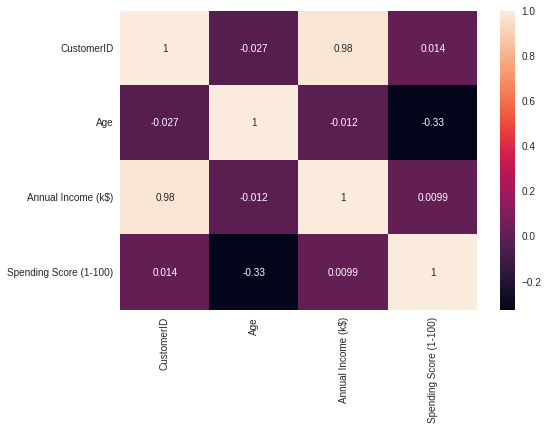

In [ ]:
# plotting correlation heatmap
dataplot = sns.heatmap(df_member_pandas.corr(), annot=True)

# displaying heatmap
plt.show()

## Clustering

In [ ]:
sel_col = ['Annual Income (k$)',	'Spending Score (1-100)', 'Age_ohe', 'Genre_ohe']
assemble = VectorAssembler(inputCols=sel_col, outputCol = 'feat_col')
assembled_df_member = assemble.transform(df_member)

In [ ]:
eval = ClusteringEvaluator(predictionCol='prediction',
                           featuresCol='feat_col',
                           metricName='silhouette',
                           distanceMeasure='squaredEuclidean')

In [ ]:
silhouette_scores=[]
print("""
Silhouette Scores for K Mean Clustering
=======================================
Model\tScore\t
=====\t=====\t
""")

for K in range(2,11):

    KMeans_algo=KMeans(featuresCol='feat_col', k=K)
    KMeans_fit=KMeans_algo.fit(assembled_df_member)
    output=KMeans_fit.transform(assembled_df_member)
    score=eval.evaluate(output)
    silhouette_scores.append(score)
    print(f"K{K}\t{round(score,2)}\t")


Silhouette Scores for K Mean Clustering
Model	Score	
=====	=====	

K2	0.52	
K3	0.63	
K4	0.66	
K5	0.74	
K6	0.73	
K7	0.63	
K8	0.64	
K9	0.62	
K10	0.59	


Text(0, 0.5, 'Silhouette Score')

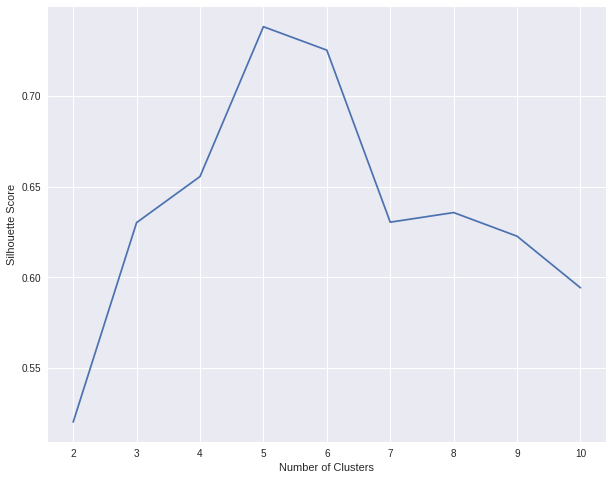

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [ ]:
KMeans_algorithm=KMeans(featuresCol='feat_col', k=5)
Model=KMeans_algorithm.fit(assembled_df_member)
KMeans_Assignments=Model.transform(assembled_df_member)

In [ ]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=2, inputCol="feat_col", outputCol="pca")
pca_model = pca.fit(assembled_df_member)
pca_transformed = pca_model.transform(assembled_df_member)

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

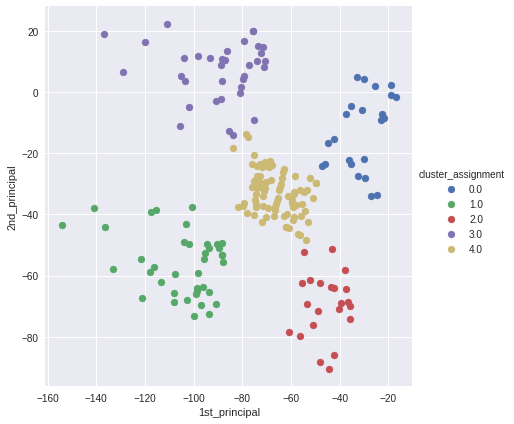

In [ ]:
pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [ ]:
KMeans_Assignments.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   39|
|         3|   35|
|         4|   81|
|         2|   22|
|         0|   23|
+----------+-----+



In [ ]:
df_member_clust = KMeans_Assignments.toPandas()
df_member_clust_pandas = pd.DataFrame(df_member_clust)
df_member_clust_pandas.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Age_udf,Age_ohe,Genre_ohe,feat_col,prediction
0,1,Male,19,15,39,usia muda,3.0,1.0,"[15.0, 39.0, 3.0, 1.0]",0
1,2,Male,21,15,81,usia muda,3.0,1.0,"[15.0, 81.0, 3.0, 1.0]",2
2,3,Female,20,16,6,usia muda,3.0,0.0,"[16.0, 6.0, 3.0, 0.0]",0
3,4,Female,23,16,77,usia muda,3.0,0.0,"[16.0, 77.0, 3.0, 0.0]",2
4,5,Female,31,17,40,usia pekerja awal,0.0,0.0,"[17.0, 40.0, 0.0, 0.0]",0


In [ ]:
for i in range(5):
  print(f'Cluster ke-{i}')
  print('Rata-rata Annual Income (k$)  : ', df_member_clust_pandas[df_member_clust_pandas['prediction']==i]['Annual Income (k$)'].mean())
  print('Rata-rata Spending Score (1-100) : ', df_member_clust_pandas[df_member_clust_pandas['prediction']==i]['Spending Score (1-100)'].mean())
  print('Rata-rata Age  : ', df_member_clust_pandas[df_member_clust_pandas['prediction']==i]['Age'].mean())
  print('Modus (nilai yang paling banyak keluar) Gender : ', round(df_member_clust_pandas[df_member_clust_pandas['prediction']==i]['Genre_ohe'].mean(), 0))

Cluster ke-0
Rata-rata Annual Income (k$)  :  26.304347826086957
Rata-rata Spending Score (1-100) :  20.91304347826087
Rata-rata Age  :  45.21739130434783
Modus (nilai yang paling banyak keluar) Gender :  0.0
Cluster ke-1
Rata-rata Annual Income (k$)  :  86.53846153846153
Rata-rata Spending Score (1-100) :  82.12820512820512
Rata-rata Age  :  32.69230769230769
Modus (nilai yang paling banyak keluar) Gender :  0.0
Cluster ke-2
Rata-rata Annual Income (k$)  :  25.727272727272727
Rata-rata Spending Score (1-100) :  79.36363636363636
Rata-rata Age  :  25.272727272727273
Modus (nilai yang paling banyak keluar) Gender :  0.0
Cluster ke-3
Rata-rata Annual Income (k$)  :  88.2
Rata-rata Spending Score (1-100) :  17.114285714285714
Rata-rata Age  :  41.114285714285714
Modus (nilai yang paling banyak keluar) Gender :  1.0
Cluster ke-4
Rata-rata Annual Income (k$)  :  55.2962962962963
Rata-rata Spending Score (1-100) :  49.51851851851852
Rata-rata Age  :  42.71604938271605
Modus (nilai yang palin

In [ ]:
df_member_clust_pandas_0= df_member_clust_pandas[df_member_clust_pandas['prediction']==0]
df_member_clust_pandas_1= df_member_clust_pandas[df_member_clust_pandas['prediction']==1]
df_member_clust_pandas_2= df_member_clust_pandas[df_member_clust_pandas['prediction']==2]
df_member_clust_pandas_3= df_member_clust_pandas[df_member_clust_pandas['prediction']==3]
df_member_clust_pandas_4= df_member_clust_pandas[df_member_clust_pandas['prediction']==4]
df_member_clust_pandas_5= df_member_clust_pandas[df_member_clust_pandas['prediction']==5]

In [ ]:
df_member_clust_pandas_0['Genre'].value_counts()

Female    14
Male       9
Name: Genre, dtype: int64

In [ ]:
df_member_clust_pandas_1['Genre'].value_counts()

Female    21
Male      18
Name: Genre, dtype: int64

In [ ]:
df_member_clust_pandas_2['Genre'].value_counts()

Female    13
Male       9
Name: Genre, dtype: int64

In [ ]:
df_member_clust_pandas_3['Genre'].value_counts()

Male      19
Female    16
Name: Genre, dtype: int64

In [ ]:
df_member_clust_pandas_4['Genre'].value_counts()

Female    48
Male      33
Name: Genre, dtype: int64

In [ ]:
# df_member_clust_pandas_2['Genre'].value_counts()

## Regression

In [ ]:
sel_col = ['Spending Score (1-100)', 'Annual Income (k$)', 'Genre_ohe']
assemble_reg = VectorAssembler(inputCols=sel_col, outputCol = 'feat_reg')
assembled_df_member_reg = assemble_reg.transform(df_member)
assembled_df_member_reg.show()

+----------+------+---+------------------+----------------------+-----------------+-------+---------+---------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|          Age_udf|Age_ohe|Genre_ohe|       feat_reg|
+----------+------+---+------------------+----------------------+-----------------+-------+---------+---------------+
|         1|  Male| 19|                15|                    39|        usia muda|    3.0|      1.0|[39.0,15.0,1.0]|
|         2|  Male| 21|                15|                    81|        usia muda|    3.0|      1.0|[81.0,15.0,1.0]|
|         3|Female| 20|                16|                     6|        usia muda|    3.0|      0.0| [6.0,16.0,0.0]|
|         4|Female| 23|                16|                    77|        usia muda|    3.0|      0.0|[77.0,16.0,0.0]|
|         5|Female| 31|                17|                    40|usia pekerja awal|    0.0|      0.0|[40.0,17.0,0.0]|
|         6|Female| 22|                17|              

In [ ]:
final_assemble_member = assembled_df_member_reg.select('feat_reg', 'Age_ohe')
final_assemble_member.show()

+---------------+-------+
|       feat_reg|Age_ohe|
+---------------+-------+
|[39.0,15.0,1.0]|    3.0|
|[81.0,15.0,1.0]|    3.0|
| [6.0,16.0,0.0]|    3.0|
|[77.0,16.0,0.0]|    3.0|
|[40.0,17.0,0.0]|    0.0|
|[76.0,17.0,0.0]|    3.0|
| [6.0,18.0,0.0]|    1.0|
|[94.0,18.0,0.0]|    3.0|
| [3.0,19.0,1.0]|    4.0|
|[72.0,19.0,0.0]|    0.0|
|[14.0,19.0,1.0]|    4.0|
|[99.0,19.0,0.0]|    1.0|
|[15.0,20.0,0.0]|    4.0|
|[77.0,20.0,0.0]|    3.0|
|[13.0,20.0,1.0]|    1.0|
|[79.0,20.0,1.0]|    3.0|
|[35.0,21.0,0.0]|    1.0|
|[66.0,21.0,1.0]|    3.0|
|[29.0,23.0,1.0]|    2.0|
|[98.0,23.0,0.0]|    1.0|
+---------------+-------+
only showing top 20 rows



In [ ]:
train_data, test_data = final_assemble_member.randomSplit(weights=[0.75,0.25], seed=42)

In [ ]:
from pyspark.ml.regression import LinearRegression

ss = LinearRegression(featuresCol='feat_reg', labelCol='Age_ohe')

In [ ]:
ss = ss.fit(train_data)

In [ ]:
ss.coefficients

DenseVector([-0.0148, -0.0168, 0.1528])

In [ ]:
ss.intercept

3.4647446059841416

In [ ]:
pred = ss.evaluate(test_data)
pred.predictions.show()

+----------------+-------+------------------+
|        feat_reg|Age_ohe|        prediction|
+----------------+-------+------------------+
|  [3.0,19.0,1.0]|    4.0|3.2538515310527742|
|  [5.0,73.0,1.0]|    3.0| 2.316420059558435|
|  [5.0,81.0,1.0]|    3.0|2.1819132437294018|
|  [6.0,16.0,0.0]|    3.0| 3.107199580380984|
|  [9.0,71.0,1.0]|    2.0| 2.291025834218966|
| [13.0,87.0,1.0]|    1.0|1.9629912732641726|
| [14.0,33.0,0.0]|    2.0|2.7033307381508345|
|[16.0,120.0,0.0]|    2.0| 1.211058651361732|
| [17.0,34.0,0.0]|    1.0|  2.64225168919966|
|[17.0,103.0,0.0]|    1.0|1.4821304026742466|
| [20.0,78.0,0.0]|    1.0|1.8581985051674308|
| [20.0,86.0,1.0]|    1.0|1.8765179989735294|
| [28.0,39.0,0.0]|    2.0|2.3958773737405146|
| [29.0,70.0,0.0]|    3.0|1.8599082300788286|
| [31.0,29.0,0.0]|    1.0| 2.519745196554261|
| [32.0,28.0,0.0]|    2.0| 2.521803316208709|
| [34.0,72.0,0.0]|    0.0|1.7525053645006616|
| [35.0,24.0,1.0]|    1.0|2.6976173367858127|
| [36.0,39.0,1.0]|    2.0| 2.43066

In [ ]:
pred_train = ss.evaluate(train_data)

In [ ]:
print('MAE for train set:', pred_train.meanAbsoluteError)
print('MAE for test set:', pred.meanAbsoluteError)

MAE for train set: 1.1179612350515
MAE for test set: 0.9538799777316394


In [ ]:
print('MSE for train set:', pred_train.meanSquaredError)
print('MSE for test set:', pred.meanSquaredError)

MSE for train set: 1.7591334088790367
MSE for test set: 1.237183540566773
